# Ins

In [1]:
!pip install medmnist
!pip install albumentations
!pip install torchmetrics
!pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
#import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import models
# from torchmetrics.classification import BinaryF1Score
from medmnist import PneumoniaMNIST
print("Imported PneumoniaMNIST")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=d89e46e5333c75388b5e43258ef24c712285a15639bad1865171695b0bd3d063
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00
Imported PneumoniaMNIST


In [2]:
!rm -rf /kaggle/working/*

# MOCECT

## prep

In [3]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

from torchvision.transforms import v2
import torchvision.transforms.v2.functional as v2f
from torchvision.transforms import InterpolationMode

imgnet_mean = [0.485, 0.456, 0.406]
imgnet_std = [0.229, 0.224, 0.225]

train_transform = v2.Compose([
    # v2.RandomResizedCrop(224),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.RandomVerticalFlip(p = 0.5),
#     v2.RandomRotation(degrees = 90),
    # v2.ToDtype(torch.float32, scale=True),
#     v2.RandomAffine(degrees = (0, 90), scale = (0.8, 0.9), shear = (-15, 15)),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale = True)]),
#     v2.GaussianNoise(mean = 0, sigma = 1e-7),
    v2.Normalize(imgnet_mean, imgnet_std)
])

empty_transform = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale = True)]),
    # v2.Grayscale(num_output_channels = 3),
    # v2.Normalize(imgnet_mean, imgnet_std)
])

val_test_transform = v2.Compose([
    # v2.Resize(256),
    v2.CenterCrop(224),
    # v2.ToDtype(torch.float32, scale=True),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale = True)]),
    v2.Normalize(imgnet_mean, imgnet_std)
])

d_trans = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale = True)]),
])

train_batch_size = 32
vt_batch_size = 32
num_workers = os.cpu_count()

# Datasets:
train_dataset = PneumoniaMNIST(
    split = "train",
    download = True,
    transform = train_transform,
    size = 224
)

val_dataset = PneumoniaMNIST(
    split = "val",
    download = True,
    transform = val_test_transform,
    size = 224
)

test_dataset = PneumoniaMNIST(
    split = "test",
    download = True,
    transform = val_test_transform,
    size = 224
)

dummy_set = PneumoniaMNIST(
    split = "train",
    download = True,
    size = 224,
    transform = d_trans
)

# Loaders:
train_loader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True,
    num_workers = num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size = vt_batch_size,
    shuffle = False,
    num_workers = num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size = vt_batch_size,
    shuffle = False,
    num_workers = num_workers
)

print("Done prepping datasets")

100%|██████████| 214384716/214384716 [00:10<00:00, 21227934.00it/s]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist_224.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist_224.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist_224.npz
Done prepping datasets


## CBAM + Model + Train

In [4]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

class ResNet(torch.nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')
        self.features = torch.nn.Sequential(*list(self.model.children())[:5])
        self.flat = nn.Flatten()
    def forward(self, x):
        for name, param in self.features.named_parameters():
            param.requires_grad = False
        x = self.features(x)
        x = self.flat(x)
        x_out = x
        return x_out

resnet = ResNet()
print(list(resnet.model.children()))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr


[1.93904448 0.67372639]

27162666 27162666 


Epoch 1/50 
------------------------------------------------------------


Training Epoch 1/50: 100%|██████████| 148/148 [00:06<00:00, 24.66batch/s, loss=0.00000, acc=0.83454, lr=[0.001]]  


Train loss: 68.55333, acc: 0.83454, npv: 0.63898, ppv: 0.93191, sen: 0.83829, spe: 0.82372, f1: 0.88263


Validation Epoch 1/50: 100%|██████████| 17/17 [00:00<00:00, 23.20batch/s, loss=6.70848, acc=0.91985] 


Val loss: 13.37874, acc: 0.91985, npv: 0.77193, ppv: 0.99150, sen: 0.89974, spe: 0.97778, f1: 0.94340
New best epoch 1

Epoch 2/50 
------------------------------------------------------------


Training Epoch 2/50: 100%|██████████| 148/148 [00:05<00:00, 29.23batch/s, loss=0.00000, acc=0.92778, lr=[0.001]] 


Train loss: 16.02099, acc: 0.92778, npv: 0.81667, ppv: 0.97386, sen: 0.92759, spe: 0.92834, f1: 0.95016


Validation Epoch 2/50: 100%|██████████| 17/17 [00:00<00:00, 22.89batch/s, loss=1.22807, acc=0.96374]


Val loss: 7.08545, acc: 0.96374, npv: 0.90845, ppv: 0.98429, sen: 0.96658, spe: 0.95556, f1: 0.97536
New best epoch 2

Epoch 3/50 
------------------------------------------------------------


Training Epoch 3/50: 100%|██████████| 148/148 [00:05<00:00, 28.27batch/s, loss=0.00000, acc=0.93819, lr=[0.001]] 


Train loss: 13.75449, acc: 0.93819, npv: 0.84160, ppv: 0.97706, sen: 0.93875, spe: 0.93657, f1: 0.95752


Validation Epoch 3/50: 100%|██████████| 17/17 [00:00<00:00, 23.48batch/s, loss=10.84654, acc=0.95038]


Val loss: 10.00155, acc: 0.95038, npv: 0.88652, ppv: 0.97389, sen: 0.95887, spe: 0.92593, f1: 0.96632

Epoch 4/50 
------------------------------------------------------------


Training Epoch 4/50: 100%|██████████| 148/148 [00:05<00:00, 28.19batch/s, loss=0.00000, acc=0.95667, lr=[0.001]] 


Train loss: 9.42817, acc: 0.95667, npv: 0.88550, ppv: 0.98411, sen: 0.95707, spe: 0.95552, f1: 0.97040


Validation Epoch 4/50: 100%|██████████| 17/17 [00:00<00:00, 23.65batch/s, loss=8.45198, acc=0.97328]


Val loss: 6.33043, acc: 0.97328, npv: 0.94161, ppv: 0.98450, sen: 0.97943, spe: 0.95556, f1: 0.98196
New best epoch 4

Epoch 5/50 
------------------------------------------------------------


Training Epoch 5/50: 100%|██████████| 148/148 [00:05<00:00, 28.92batch/s, loss=0.00000, acc=0.93628, lr=[0.001]]  


Train loss: 17.71063, acc: 0.93628, npv: 0.84054, ppv: 0.97445, sen: 0.93875, spe: 0.92916, f1: 0.95627


Validation Epoch 5/50: 100%|██████████| 17/17 [00:00<00:00, 23.81batch/s, loss=19.72886, acc=0.96183]


Val loss: 6.00564, acc: 0.96183, npv: 0.90210, ppv: 0.98425, sen: 0.96401, spe: 0.95556, f1: 0.97403
New best epoch 5

Epoch 6/50 
------------------------------------------------------------


Training Epoch 6/50: 100%|██████████| 148/148 [00:05<00:00, 28.93batch/s, loss=0.00000, acc=0.96623, lr=[0.001]] 


Train loss: 9.50929, acc: 0.96623, npv: 0.91051, ppv: 0.98715, sen: 0.96709, spe: 0.96376, f1: 0.97701


Validation Epoch 6/50: 100%|██████████| 17/17 [00:00<00:00, 23.69batch/s, loss=37.11340, acc=0.92748]


Val loss: 17.78414, acc: 0.92748, npv: 0.78698, ppv: 0.99437, sen: 0.90746, spe: 0.98519, f1: 0.94892

Epoch 7/50 
------------------------------------------------------------


Training Epoch 7/50: 100%|██████████| 148/148 [00:04<00:00, 29.67batch/s, loss=0.00000, acc=0.96623, lr=[0.001]] 


Train loss: 7.89470, acc: 0.96623, npv: 0.90987, ppv: 0.98743, sen: 0.96680, spe: 0.96458, f1: 0.97701


Validation Epoch 7/50: 100%|██████████| 17/17 [00:00<00:00, 23.53batch/s, loss=35.40269, acc=0.92176]


Val loss: 17.37244, acc: 0.92176, npv: 0.77011, ppv: 0.99714, sen: 0.89717, spe: 0.99259, f1: 0.94452

Epoch 8/50 
------------------------------------------------------------


Training Epoch 8/50: 100%|██████████| 148/148 [00:05<00:00, 29.58batch/s, loss=0.00000, acc=0.96878, lr=[0.001]]  


Train loss: 7.95165, acc: 0.96878, npv: 0.91778, ppv: 0.98776, sen: 0.96995, spe: 0.96540, f1: 0.97877


Validation Epoch 8/50: 100%|██████████| 17/17 [00:00<00:00, 24.03batch/s, loss=37.42043, acc=0.89504]


Val loss: 21.61879, acc: 0.89504, npv: 0.71053, ppv: 1.00000, sen: 0.85861, spe: 1.00000, f1: 0.92393

Epoch 9/50 
------------------------------------------------------------


Training Epoch 9/50: 100%|██████████| 148/148 [00:04<00:00, 29.87batch/s, loss=60.15562, acc=0.97621, lr=[0.001]]


Train loss: 4.90690, acc: 0.97621, npv: 0.93454, ppv: 0.99157, sen: 0.97624, spe: 0.97611, f1: 0.98385


Validation Epoch 9/50: 100%|██████████| 17/17 [00:00<00:00, 23.93batch/s, loss=24.06996, acc=0.95992]


Val loss: 20.27882, acc: 0.95992, npv: 0.97500, ppv: 0.95545, sen: 0.99229, spe: 0.86667, f1: 0.97352

Epoch 10/50 
------------------------------------------------------------


Training Epoch 10/50: 100%|██████████| 148/148 [00:05<00:00, 29.53batch/s, loss=0.00000, acc=0.96559, lr=[0.001]] 


Train loss: 10.20546, acc: 0.96559, npv: 0.91158, ppv: 0.98571, sen: 0.96766, spe: 0.95964, f1: 0.97660


Validation Epoch 10/50: 100%|██████████| 17/17 [00:00<00:00, 23.43batch/s, loss=0.00000, acc=0.96183]


Val loss: 10.89283, acc: 0.96183, npv: 0.88591, ppv: 0.99200, sen: 0.95630, spe: 0.97778, f1: 0.97382

Epoch 11/50 
------------------------------------------------------------


Training Epoch 11/50: 100%|██████████| 148/148 [00:05<00:00, 29.16batch/s, loss=0.00000, acc=0.97005, lr=[0.001]]  


Train loss: 8.26077, acc: 0.97005, npv: 0.92211, ppv: 0.98778, sen: 0.97167, spe: 0.96540, f1: 0.97966


Validation Epoch 11/50: 100%|██████████| 17/17 [00:00<00:00, 21.51batch/s, loss=57.96933, acc=0.88931]


Val loss: 34.70865, acc: 0.88931, npv: 0.69948, ppv: 1.00000, sen: 0.85090, spe: 1.00000, f1: 0.91944

Epoch 12/50 
------------------------------------------------------------


Training Epoch 12/50: 100%|██████████| 148/148 [00:04<00:00, 29.62batch/s, loss=0.00000, acc=0.97302, lr=[0.0005]] 


Train loss: 6.01608, acc: 0.97302, npv: 0.92296, ppv: 0.99182, sen: 0.97167, spe: 0.97694, f1: 0.98164


Validation Epoch 12/50: 100%|██████████| 17/17 [00:00<00:00, 24.09batch/s, loss=11.59946, acc=0.95802]


Val loss: 7.97600, acc: 0.95802, npv: 0.86452, ppv: 0.99729, sen: 0.94602, spe: 0.99259, f1: 0.97098

Epoch 13/50 
------------------------------------------------------------


Training Epoch 13/50: 100%|██████████| 148/148 [00:04<00:00, 29.73batch/s, loss=0.00000, acc=0.98280, lr=[0.0005]] 


Train loss: 3.72982, acc: 0.98280, npv: 0.95429, ppv: 0.99307, sen: 0.98369, spe: 0.98023, f1: 0.98835


Validation Epoch 13/50: 100%|██████████| 17/17 [00:00<00:00, 23.57batch/s, loss=0.00000, acc=0.98473] 


Val loss: 7.60727, acc: 0.98473, npv: 0.96350, ppv: 0.99225, sen: 0.98715, spe: 0.97778, f1: 0.98969

Epoch 14/50 
------------------------------------------------------------


Training Epoch 14/50: 100%|██████████| 148/148 [00:05<00:00, 28.98batch/s, loss=0.00000, acc=0.99087, lr=[0.0005]] 


Train loss: 2.00268, acc: 0.99087, npv: 0.97563, ppv: 0.99626, sen: 0.99141, spe: 0.98929, f1: 0.99383


Validation Epoch 14/50: 100%|██████████| 17/17 [00:00<00:00, 24.14batch/s, loss=0.00000, acc=0.98092]


Val loss: 5.61995, acc: 0.98092, npv: 0.94964, ppv: 0.99221, sen: 0.98201, spe: 0.97778, f1: 0.98708
New best epoch 14

Epoch 15/50 
------------------------------------------------------------


Training Epoch 15/50: 100%|██████████| 148/148 [00:05<00:00, 29.56batch/s, loss=0.00000, acc=0.98364, lr=[0.0005]] 


Train loss: 4.28696, acc: 0.98364, npv: 0.95589, ppv: 0.99364, sen: 0.98426, spe: 0.98188, f1: 0.98893


Validation Epoch 15/50: 100%|██████████| 17/17 [00:00<00:00, 23.58batch/s, loss=0.00000, acc=0.97519] 


Val loss: 9.98970, acc: 0.97519, npv: 0.95522, ppv: 0.98205, sen: 0.98458, spe: 0.94815, f1: 0.98331

Epoch 16/50 
------------------------------------------------------------


Training Epoch 16/50: 100%|██████████| 148/148 [00:05<00:00, 29.51batch/s, loss=0.00000, acc=0.99448, lr=[0.0005]] 


Train loss: 0.82351, acc: 0.99448, npv: 0.98371, ppv: 0.99828, sen: 0.99428, spe: 0.99506, f1: 0.99627


Validation Epoch 16/50: 100%|██████████| 17/17 [00:00<00:00, 23.65batch/s, loss=0.00000, acc=0.96565] 


Val loss: 17.97313, acc: 0.96565, npv: 0.96063, ppv: 0.96725, sen: 0.98715, spe: 0.90370, f1: 0.97710

Epoch 17/50 
------------------------------------------------------------


Training Epoch 17/50: 100%|██████████| 148/148 [00:05<00:00, 28.31batch/s, loss=0.00000, acc=0.99065, lr=[0.0005]] 


Train loss: 1.73716, acc: 0.99065, npv: 0.97484, ppv: 0.99626, sen: 0.99113, spe: 0.98929, f1: 0.99369


Validation Epoch 17/50: 100%|██████████| 17/17 [00:00<00:00, 23.55batch/s, loss=5.94306, acc=0.97519]


Val loss: 7.11660, acc: 0.97519, npv: 0.94203, ppv: 0.98705, sen: 0.97943, spe: 0.96296, f1: 0.98323

Epoch 18/50 
------------------------------------------------------------


Training Epoch 18/50: 100%|██████████| 148/148 [00:04<00:00, 29.76batch/s, loss=0.00000, acc=0.99235, lr=[0.0005]] 


Train loss: 1.21262, acc: 0.99235, npv: 0.97808, ppv: 0.99741, sen: 0.99227, spe: 0.99259, f1: 0.99484


Validation Epoch 18/50: 100%|██████████| 17/17 [00:00<00:00, 23.89batch/s, loss=16.14327, acc=0.95802]


Val loss: 30.40361, acc: 0.95802, npv: 0.99130, ppv: 0.94866, sen: 0.99743, spe: 0.84444, f1: 0.97243

Epoch 19/50 
------------------------------------------------------------


Training Epoch 19/50: 100%|██████████| 148/148 [00:04<00:00, 29.72batch/s, loss=0.00000, acc=0.98258, lr=[0.0005]] 


Train loss: 3.29884, acc: 0.98258, npv: 0.95280, ppv: 0.99335, sen: 0.98311, spe: 0.98105, f1: 0.98820


Validation Epoch 19/50: 100%|██████████| 17/17 [00:00<00:00, 23.43batch/s, loss=0.00000, acc=0.97328] 


Val loss: 12.93196, acc: 0.97328, npv: 0.94815, ppv: 0.98201, sen: 0.98201, spe: 0.94815, f1: 0.98201

Epoch 20/50 
------------------------------------------------------------


Training Epoch 20/50: 100%|██████████| 148/148 [00:04<00:00, 29.74batch/s, loss=0.00000, acc=0.99363, lr=[0.0005]] 


Train loss: 0.92389, acc: 0.99363, npv: 0.98130, ppv: 0.99799, sen: 0.99342, spe: 0.99423, f1: 0.99570


Validation Epoch 20/50: 100%|██████████| 17/17 [00:00<00:00, 23.43batch/s, loss=12.39559, acc=0.95038]


Val loss: 14.98399, acc: 0.95038, npv: 0.84713, ppv: 0.99455, sen: 0.93830, spe: 0.98519, f1: 0.96561

Epoch 21/50 
------------------------------------------------------------


Training Epoch 21/50: 100%|██████████| 148/148 [00:04<00:00, 30.14batch/s, loss=0.00000, acc=0.99554, lr=[0.00025]]


Train loss: 0.89469, acc: 0.99554, npv: 0.98774, ppv: 0.99828, sen: 0.99571, spe: 0.99506, f1: 0.99699


Validation Epoch 21/50: 100%|██████████| 17/17 [00:00<00:00, 23.72batch/s, loss=0.00000, acc=0.97328] 


Val loss: 9.86098, acc: 0.97328, npv: 0.95489, ppv: 0.97954, sen: 0.98458, spe: 0.94074, f1: 0.98205

Epoch 22/50 
------------------------------------------------------------


Training Epoch 22/50: 100%|██████████| 148/148 [00:05<00:00, 28.87batch/s, loss=0.00000, acc=0.99490, lr=[0.00025]]


Train loss: 0.61598, acc: 0.99490, npv: 0.98532, ppv: 0.99828, sen: 0.99485, spe: 0.99506, f1: 0.99656


Validation Epoch 22/50: 100%|██████████| 17/17 [00:00<00:00, 21.20batch/s, loss=0.00000, acc=0.97710] 


Val loss: 12.08823, acc: 0.97710, npv: 0.96241, ppv: 0.98210, sen: 0.98715, spe: 0.94815, f1: 0.98462

Epoch 23/50 
------------------------------------------------------------


Training Epoch 23/50: 100%|██████████| 148/148 [00:04<00:00, 29.96batch/s, loss=0.00000, acc=0.99511, lr=[0.00025]]


Train loss: 0.96138, acc: 0.99511, npv: 0.98692, ppv: 0.99799, sen: 0.99542, spe: 0.99423, f1: 0.99670


Validation Epoch 23/50: 100%|██████████| 17/17 [00:00<00:00, 23.77batch/s, loss=0.00000, acc=0.97137] 


Val loss: 10.61386, acc: 0.97137, npv: 0.95455, ppv: 0.97704, sen: 0.98458, spe: 0.93333, f1: 0.98079

Epoch 24/50 
------------------------------------------------------------


Training Epoch 24/50: 100%|██████████| 148/148 [00:04<00:00, 29.74batch/s, loss=0.00000, acc=0.99596, lr=[0.00025]] 


Train loss: 0.56094, acc: 0.99596, npv: 0.98855, ppv: 0.99857, sen: 0.99599, spe: 0.99588, f1: 0.99728


Validation Epoch 24/50: 100%|██████████| 17/17 [00:00<00:00, 23.30batch/s, loss=0.00000, acc=0.97519] 


Val loss: 11.96451, acc: 0.97519, npv: 0.96212, ppv: 0.97959, sen: 0.98715, spe: 0.94074, f1: 0.98335
Early stopping at epoch 24
Model saved at /kaggle/working/early_stop_model_epoch_24.pth


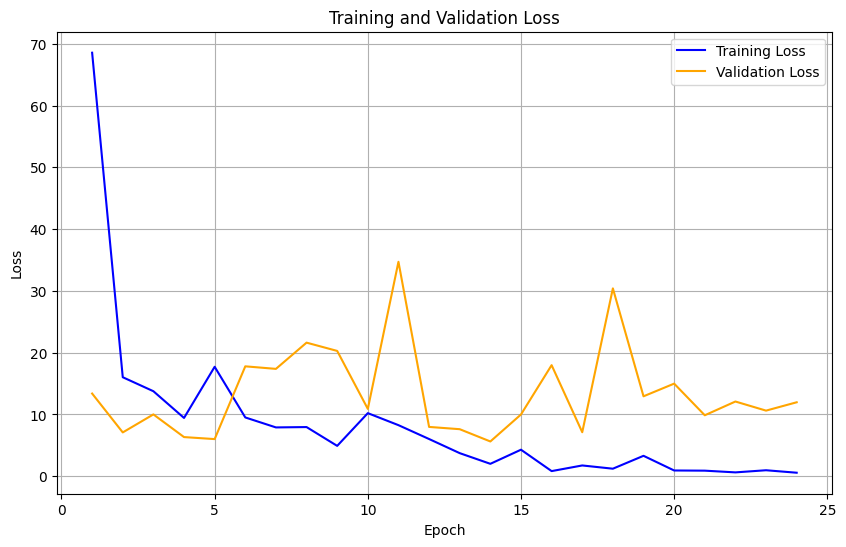

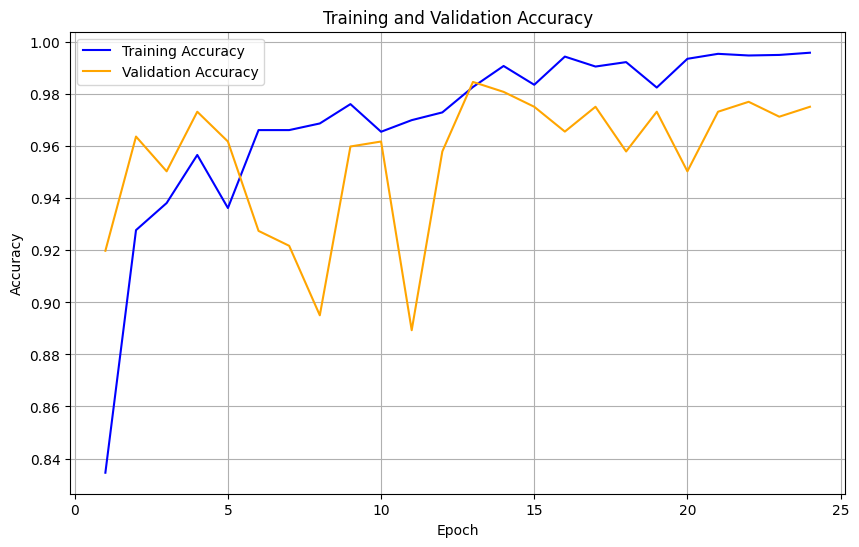

In [5]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

class ResNet(torch.nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')
        self.features = torch.nn.Sequential(*list(self.model.children())[:5])
        self.flat = nn.Flatten()
    def forward(self, x):
        for name, param in self.features.named_parameters():
            param.requires_grad = False
        x = self.features(x)
        x = self.flat(x)
        x_out = x
        return x_out

resnet = ResNet()

class Head(torch.nn.Module):
    def __init__(self):
        super(Head, self).__init__()
        self.mlp_head = torch.nn.Sequential(
#             torch.nn.Linear(768, 2),
#             nn.Linear(256, 2) # ABL 1 REFER TO HANDBOOK
             nn.Linear(802816, 2) # 256 
        )

    def forward(self, x):
        return self.mlp_head(x)


class MOCECT(torch.nn.Module):
    def __init__(self):
        super(MOCECT, self).__init__()
        self.resnet = ResNet()
        self.head = Head()
        
    def forward(self, x, features=False):
        f_vgg = self.resnet(x)
        out = f_vgg
        if features:
            return out
        else:
            return self.head(out)

from sklearn.utils.class_weight import compute_class_weight
train_classes =  np.unique(train_dataset.labels)
train_labels = train_dataset.labels.ravel()
class_weights = compute_class_weight(class_weight='balanced', classes=train_classes, y=train_labels)

print(f"\n{class_weights}\n")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MOCECT().to(device)
pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_all_params = sum(p.numel() for p in model.parameters())

print(pytorch_train_params, pytorch_all_params, "\n")

#TRAIN:

import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Set up the device (CUDA if available)


# Set Kaggle working directory for saving model, optimizer, and logs
kaggle_working_directory = "/kaggle/working/"

# Evaluation function
def evaluation(true_labels, pred_labels):
    true_labels = torch.cat(true_labels).cpu().numpy()
    pred_labels = torch.cat(pred_labels).cpu().numpy()

    tp = ((pred_labels == 1) & (true_labels == 1)).sum()
    tn = ((pred_labels == 0) & (true_labels == 0)).sum()
    fp = ((pred_labels == 1) & (true_labels == 0)).sum()
    fn = ((pred_labels == 0) & (true_labels == 1)).sum()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1_score = 2 * ppv * sensitivity / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0.0

    return accuracy, npv, ppv, sensitivity, specificity, f1_score

# Training parameters
learning_rate = 1e-3#1e-3
min_lr = 1e-4
batch_size = train_batch_size
num_epochs = 50
weight_decay = 1e-3
alter_lr_patience = 5
lr_factor = 0.5 #0.5
use_pretrained = False
min_loss = 1e5 if not use_pretrained else 0.1488228 # UPDATE MIN LOSS IF USING PRETRAINED
sepoch = 0

# Initialize the optimizer, loss function, and learning rate scheduler
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
loss_func = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
if use_pretrained:
    opt_state_name = "best_optimizer_epoch_27.pth"
    opt_state = torch.load(os.path.join(kaggle_working_directory, opt_state_name), weights_only = True)
    optimizer.load_state_dict(opt_state)
    model_state_name = "best_model_epoch_27.pth"
    mod_state = torch.load(os.path.join(kaggle_working_directory, model_state_name), weights_only = True)
    model.load_state_dict(mod_state)
    sepoch = 27
    
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=lr_factor, patience=alter_lr_patience)

# Early stopping logic
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Instantiate the early stopper
# prev min_delta = 0.001
early_stopper = EarlyStopper(patience=10, min_delta=0.001)

# Lists to store losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    t_loss_b, v_loss_b, train_in, val_in = 0, 0, 0, 0
    t_tle, t_ple, v_tle, v_ple = [], [], [], []
    print(f'\nEpoch {sepoch+epoch + 1}/{sepoch+num_epochs} \n' + '-' * 60)

    model.train()

    with tqdm(total=len(train_loader), desc=f"Training Epoch {sepoch + epoch + 1}/{sepoch+num_epochs}", unit="batch") as pbar:
        for step, (t_x, t_y) in enumerate(train_loader):
            t_x, t_y = t_x.to(device), t_y.to(device).squeeze(1)  # Handle (batch_size, 1) shape
            t_tle.append(t_y)
            output = model(t_x)

            loss = loss_func(output, t_y.long())  # Ensure t_y is of shape (batch_size,)
            lab = torch.argmax(output, dim=1)
            t_ple.append(lab)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t_loss_b += loss.item() * t_x.size(0)
            train_in += t_x.size(0)

            # Update progress bar with loss and accuracy
            t_acc = (torch.cat(t_ple) == torch.cat(t_tle)).float().mean().item()
            pbar.set_postfix({"loss": f"{loss.item():.5f}", "acc": f"{t_acc:.5f}", "lr": scheduler.get_last_lr()})
            pbar.update(1)

    t_loss = t_loss_b / len(train_loader.dataset)
    t_acc, t_npv, t_ppv, t_sen, t_spe, t_f1 = evaluation(t_tle, t_ple)
    train_losses.append(t_loss)
    train_accuracies.append(t_acc)
    print(f"Train loss: {t_loss:.5f}, acc: {t_acc:.5f}, npv: {t_npv:.5f}, ppv: {t_ppv:.5f}, sen: {t_sen:.5f}, spe: {t_spe:.5f}, f1: {t_f1:.5f}")

    if val_loader is not None:
        model.eval()
        with torch.no_grad():
            with tqdm(total=len(val_loader), desc=f"Validation Epoch {sepoch + epoch + 1}/{sepoch + num_epochs}", unit="batch") as pbar:
                for step, (v_x, v_y) in enumerate(val_loader):
                    v_x, v_y = v_x.to(device), v_y.to(device).squeeze(1)
                    v_tle.append(v_y)
                    output = model(v_x)

                    loss = loss_func(output, v_y.long())
                    lab = torch.argmax(output, dim=1)
                    v_ple.append(lab)
                    v_loss_b += loss.item() * v_x.size(0)
                    val_in += v_x.size(0)

                    v_acc = (torch.cat(v_ple) == torch.cat(v_tle)).float().mean().item()
                    pbar.set_postfix({"loss": f"{loss.item():.5f}", "acc": f"{v_acc:.5f}"})
                    pbar.update(1)

        v_loss = v_loss_b / len(val_loader.dataset)
        v_acc, v_npv, v_ppv, v_sen, v_spe, v_f1 = evaluation(v_tle, v_ple)
        val_losses.append(v_loss)
        val_accuracies.append(v_acc)
        print(f"Val loss: {v_loss:.5f}, acc: {v_acc:.5f}, npv: {v_npv:.5f}, ppv: {v_ppv:.5f}, sen: {v_sen:.5f}, spe: {v_spe:.5f}, f1: {v_f1:.5f}")

        scheduler.step(v_loss)

        # Early stopping check
        if early_stopper.early_stop(v_loss):
            print(f"Early stopping at epoch {sepoch+epoch + 1}")
            # Save the model upon early stopping
            model_save_path = os.path.join(kaggle_working_directory, f"early_stop_model_epoch_{sepoch+epoch+1}.pth")
            optimizer_save_path = os.path.join(kaggle_working_directory, f"early_stop_optimizer_epoch_{sepoch+epoch+1}.pth")
            torch.save(model.state_dict(), model_save_path)
            torch.save(optimizer.state_dict(), optimizer_save_path)
            print(f"Model saved at {model_save_path}")
            break

        # Track the best epoch based on validation loss
        if v_loss < min_loss:
            min_loss = v_loss
            print(f"New best epoch {sepoch+epoch + 1}")
            # Save the model state and optimizer
            model_save_path = os.path.join(kaggle_working_directory, f"best_model_epoch_{sepoch+epoch+1}.pth")
            optimizer_save_path = os.path.join(kaggle_working_directory, f"best_optimizer_epoch_{sepoch+epoch+1}.pth")
#             if epoch > 15:
            torch.save(model.state_dict(), model_save_path)
            torch.save(optimizer.state_dict(), optimizer_save_path)

    else:
        print(f'Training only. Loss: {t_loss:.5f}, Accuracy: {t_acc:.5f}')

# Plot and save training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(kaggle_working_directory, "loss_curve.png"))
plt.show()

# Plot and save training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(kaggle_working_directory, "accuracy_curve.png"))
plt.show()


## test

/tmp/ipykernel_36/2810174636.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_path, map_location=device)


Model testing started


Testing: 100%|██████████| 20/20 [00:00<00:00, 23.43batch/s]


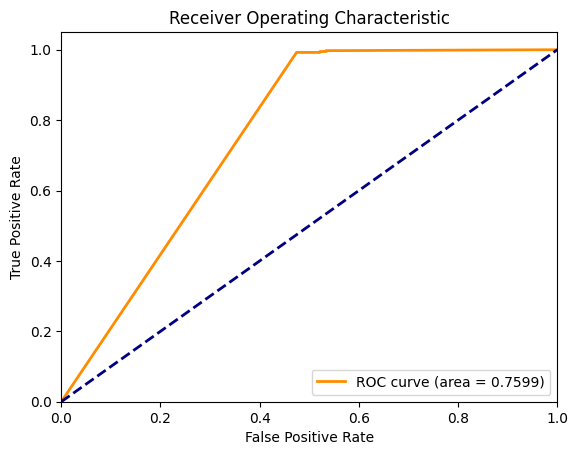

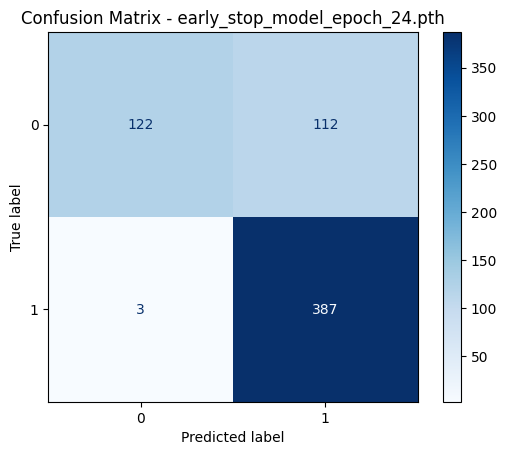

Test done in 0.0 m 0.8606307506561279 s 
Test loss: 105.88384, acc: 0.81571, npv: 0.97600, ppv: 0.77555, sen: 0.99231, spe: 0.52137, fos: 0.87064, fpr: 0.47863


In [7]:
import time
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F

# Evaluation function to calculate accuracy, npv, ppv, etc.
def evaluation(true_labels, pred_labels):
    true_labels = torch.cat(true_labels).cpu().numpy()
    pred_labels = torch.cat(pred_labels).cpu().numpy()

    tp = ((pred_labels == 1) & (true_labels == 1)).sum()
    tn = ((pred_labels == 0) & (true_labels == 0)).sum()
    fp = ((pred_labels == 1) & (true_labels == 0)).sum()
    fn = ((pred_labels == 0) & (true_labels == 1)).sum()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0  # Precision
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # True negative rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0  # False positive rate
    f1_score = 2 * ppv * sensitivity / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0.0

    return accuracy, npv, ppv, sensitivity, specificity, f1_score, fpr

# Define the test function
def test(model_name, model_class, test_loader, log_directory, bp=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set loss function (using CrossEntropyLoss)
    loss_func = torch.nn.CrossEntropyLoss()

    # Load the model and push to device
    model = model_class().to(device)
    model_path = os.path.join(log_directory, model_name)
    model_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(model_dict)

    # Initialize tracking variables
    te_loss, te_loss_b, te_in = 0, 0, 0
    te_tle, te_ple = [], []
    all_probs = []

    print('Model testing started')
    since = time.time()
    model.eval()

    for step, (t_x, t_y) in enumerate(tqdm(test_loader, desc="Testing", unit="batch")):
        t_x, t_y = t_x.to(device), t_y.to(device).squeeze(1)
        te_tle.append(t_y)
        output = model(t_x)

        # Compute loss and probabilities
        loss = loss_func(output, t_y.long())
        probs = torch.softmax(output, dim=1)[:, 1]  # Probability of the positive class
        all_probs.append(probs.detach().cpu().numpy())  # Detach and convert to numpy

        # Determine the predicted labels
        lab = torch.argmax(output, dim=1)
        te_ple.append(lab)
        te_loss_b += loss.item() * t_x.size(0)
        te_in += t_x.size(0)

    # Final calculations
    t_c = time.time() - since
    te_loss = te_loss_b / len(test_loader.dataset)
    te_acc, te_npv, te_ppv, te_sen, te_spe, te_fos, te_fpr = evaluation(te_tle, te_ple)

    # Flatten the list of probabilities and true labels for ROC and confusion matrix
    all_probs = np.concatenate(all_probs)
    true_labels = torch.cat(te_tle).cpu().numpy()

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(true_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve and save
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig("/kaggle/working/roc_curve.png")
    plt.show()

    # Compute confusion matrix
    pred_labels = torch.cat(te_ple).cpu().numpy()
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig("/kaggle/working/confusion_matrix.png")
    plt.show()

    # Print summary metrics
    print(f'Test done in {t_c // 60} m {t_c % 60} s \nTest loss: {te_loss:.5f}, acc: {te_acc:.5f}, '
          f'npv: {te_npv:.5f}, ppv: {te_ppv:.5f}, sen: {te_sen:.5f}, spe: {te_spe:.5f}, fos: {te_fos:.5f}, fpr: {te_fpr:.5f}')

# Example usage:
log_directory = "/kaggle/working"
model_name = "early_stop_model_epoch_37.pth"  # Set your model name here
model_class = MOCECT  # Define your model class here
test_batch_size = 32

# Define your test DataLoader here
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=os.cpu_count())

# Run the test function
# test(model_name, model_class, test_loader, log_directory, bp=False)
# test("best_model_epoch_27.pth", model_class, test_loader, log_directory, bp = False)
def ftest(model_name):
    test(model_name, model_class, test_loader, log_directory, bp = False)
ftest("early_stop_model_epoch_24.pth")

